# ADM - HW 3

In [1]:
import functions 

from bs4 import BeautifulSoup
import requests
import os 
import time
import pandas as pd 
import csv 
import nltk
import calendar
from nltk.corpus import stopwords
import numpy as np
from collections import Counter
from functools import reduce
import pickle 
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
import heapq
from collections import Counter
import re
from rank_bm25 import BM25Okapi
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
import plotly.express as px


# 1. Data Collection

## 1.1 Get the list of master's degree courses

The code for this section can be found in the *crawler.py* file. 


Our process for retrieving the lisks consist in first creating a list containing the urls to all the 6000 courses contained in the 400 pages, then, after making sure we have all the urls by checking the lenght of this list, we write them in a *.txt. file. The main reason we decided not to write directly the urls on a file is because we wanted to be able to check quickly if we had all the urls, since this process gave us some troubles.

To compile the list:
1. we designed a function, *extract_masters* that for each page in the catalogue, retrieves all the 15 links to the courses and returns them in a list;
2. we iterate on the firsts 400 pages and call the above mentioned function on every page, updating the list with all the links by appending the resuls obtained for each age to the "main list".

To iterate on the 400 pages, we noticed that the url of th various pages is *https://www.findamasters.com/masters-degrees/msc-degrees/?PG=* followed by the number of the page in the MSc courses catalogue we're in, so we updated the url of each page by changing the number of the page at each iteration.




## 1.2 Crawl master's degree pages 

The code for this section can be found in *crawler.py*. 

After writing the *.txt* file containing all the urls to the MSc courses pages, we need to download each page corresponding html file. To do so, we iterate with a for loop over the number of the pages of the MSc courses catalogue and, for each page, we first select the link contained in that page from the list created for point 1.1, then we iterate through this sublist and download the html of each page putting it in the correct folder.    

In order to be able to download the htmls, we complete the url of the page by adding "https://www.findamasters.com/" at the beginning of each link we have, then we use this complete url as an input for the function we designed to download the htmls.   
This function, *download_html*, takes in input two variables: the url of the page we need to download and the destination folder. It first creates the non-already exsting folders, then downloads the html files, saving them with the "filename" we decided to give them by usign requests and BeautifulSoup. For the filename, we decided to keep the "relevant part" of the url (the one that has inside the name of the MSc degree and its identification code at the end of the url), but we replaced "/" with underscores since "/" character messes up the file directory. 



## 1.3 Parse downloaded pages

The code for this section can be found inside the *parser.py* file.

In this section of the homework, we were asked to create 6000 *.tsv* files, each one containing some relevant info about the course.
To do so, we access to all the .html files we downloaded in the previous point by iterating throguh the 400 folders we created and accessing the 15 files inside each folder, one by one, and applying on each of them the function we created to solve this task, *get_attributes*, and using the output of this function to write the *.tsv* file.

The function first initializes the output values as empty strings, then goes trough the document given in input to find the info needed. Each of this info is obtained by exploiting the html structure of the file: each info is stored in a particular element of the html, that we identified using the "Inspect" web based tool. Some of the info we obtained from the html are also processed inside the function, since for some courses they were multi-line info, or they were stored in different paragraph in the html. 

Besides, after saving all these files, we merged them to have only one *.csv* file containing all the dataset, and this is the file we are using to load the dataset below. The code we used to merge all the files can be seen can be found in the file *dataset_creation.py*.


Now that we made our explainations, let's load the dataset.

In [2]:
#load dataset
msc_degrees = pd.read_csv('msc_degrees.csv')

#show dataset
msc_degrees

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
0,Advanced Physiotherapy Practice - MSc,Glasgow Caledonian University,School of Health and Life Sciences,Full time,Progress your career as a physiotherapist wit...,"January, September",Please see the university website for further...,MSc,1 Year Full Time / 2-3 Years Part Time,Glasgow,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/...
1,Advanced Master in Innovation & Strategic Mana...,Solvay Brussels School,Economics and Management,Full time,Programme overview The Advanced Master in I...,September,18.000 €,MA MSc Other Pre-Masters Masters Module,10 months,Brussels,Belgium,On Campus,https://www.findamasters.com/masters-degrees/...
2,"Accounting, Financial Management and Digital B...",University of Reading,Henley Business School,Full time,Embark on a professional accounting career wi...,September,Please see the university website for further...,MSc,1 year full time,Reading,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/...
3,Analytical Toxicology MSc,King’s College London,Faculty of Life Sciences & Medicine,Full time,The Analytical Toxicology MSc is a unique stu...,See Course,Please see the university website for further...,MSc,Full-time: One year,London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/...
4,Accounting and Finance - MSc,University of Leeds,Leeds University Business School,Full time,Businesses and governments rely on sound fina...,September,"UK: £18,000 (Total) International: £34,750 (...",MSc,1 year full time,Leeds,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,"Masters of Science in Business, Supply Chain A...",Oregon State University,School of Business,Full time,Master of Science in Business (MSB) Our Mas...,See Course,Please see the university website for further...,MSc,12 months,Corvallis,USA,Online,https://www.findamasters.com/masters-degrees/...
5996,Material Culture & Artefact Studies - MSc/PgDip,University of Glasgow,College of Arts & Humanities,Full time,Material culture and artefact studies combine...,September,Please see the university website for further...,MSc PGDip,"9-12 months full-time, 18-24 months part-time",Glasgow,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/...
5997,Master's of Computer Science,Harbour.Space University,Masters Programmes,Full time,Harbour.Space’s Master's of Computer Science ...,"September, January","€29,900/year",MSc,1 year or 2 years,Barcelona,Spain,On Campus,https://www.findamasters.com/masters-degrees/...
5998,Master's of Financial Technology (Fintech),Harbour.Space University,Masters Programmes,Full time,Harbour.Space's FinTech Master programme ...,"September, January","€29,900/year",MBA MSc,1 Year,Barcelona,Spain,On Campus,https://www.findamasters.com/masters-degrees/...


# 2. Search Engine

## 2.0 Preprocessing

### 2.0.0  Preprocessing the text

We are required to preprocess all the informations retrieved for the courses, but since loosing punctuation in the url will lead us to loose its functionality, we won't preprocess that column (also, the info contained in the url aren't textual info). Moreover, we won't preprocess the fees column since there's a particoular preprocessing required for that column.

The columns we decided to preprocess in this point and the operation we decided to perform are the following: 
- 'description' column: removing punctuation and stopwords, stemming
- 'startDate' column: eliminating everithing that is not a month by using calendar.month_name 

Before being able to proceed, we had to download 'punkt' and 'stopwords' from nltk. 

In [3]:
#'descritpion' column 
stopw = stopwords.words('english')
msc_degrees['description_clean'] = msc_degrees.description.apply(lambda row: nltk.word_tokenize(row)).apply(lambda row: ([nltk.PorterStemmer().stem(word) for word in row if (word.isalnum() and (not word in stopw))])) 

#'startDate' column
msc_degrees['startDate_clean']= msc_degrees.startDate.apply(lambda row: nltk.word_tokenize(row)).apply(lambda row: ' '.join([month for month in row if month in calendar.month_name[1:]])) #[1:] beacuse calendar.month_name contains an empty name as first element

### 2.0.1 - Preprocessing the fees columns

First of all, we notice that there are a lot of courses for which we are addressed to the University's site to see fees' informations, and for these courses, th 'fees' columns says: *"Please see the university website for further information on fees for this course."*. For this reason, we replace such stirng with an empty one under the *'fees_EUR'* column in order to speed up operations.   
After applying only this operation, we checked and saw that in the 'fees_EUR' column there were now more than 4000 empty rows, making our operaion useful.

Now let's get started with the rest of the preprocessing operations for this column. 
First of all, we need to retrieve all the money-related numeric values and their currencies. To do so, we used two different regex patterns, one identifing the fees written as *currency* *numeric value* (like £400, for example) and the other one identifieng the reverse couple, so *numeric value* *currency* (ex: 400£). 
For the currencies simbols we used the pattern found in the second answer gievn here https://stackoverflow.com/questions/25978771/what-is-regex-for-currency-symbol, then we added some currency abbreviations, starting from the most common then continuing by personally looking at the rows in the dataset that didn't give us any match to find if we were missing any value. 
While doing this procedure, we also noticed that between the ones withouth matches, we have a lot of rows structured like the following: "*UK Fees: 2022/23 fees TBC*;2021/22 fees - 10400   International Fees: 2022/23 fees TBC*;2021/22 fees - 17900*".

For these lines, we checked the country (that is always UK, as we suspected), so we assumed that the currency corresponding to the fees values we see is £, even if not explicitly written. 
For these reasons, for these lines we procede in the following way:
1. match 'UK FEES' at the beginnning of the line;
2. search for all the numeric values, clean them by removing '.' and ',';
3. save numerical values + £ in the 'fees_EUR' column. 

Moreover, in order not to match the numeric values corresponding to the academic years, we added a space at the end of each line and looked at numeric values or bounded by two blankspaces, or preceded by an asterisk or a blankspace and followed by a blankspace, which are the only two consistent structures we found for this type of rows.


After retrieving the fees values, we needed to conver them all to a common currency (we chose euros), and return the maximum between them in order to retrieve the highest fee for the lines that have more than one suitable value. We first made the conversion then got the maximum (and not the opposite) since there are some rows where the fees have different currencies, so returning the maximum numeric value and then converting it to euros would be incorrect since we sould be compairing numbers that have different units of measurement.

For the conversion, we need to convert all the currency symbols and abbreviations found in the dataset into their corresponding ISO currency. To do so, we created a dictionary  that has as keys the currency found in the dataset and as values their ISO correspondacy. This dictionary is loaded here as 'ISO_currency_dict' and has previously been saved into "ISOcurrency.pkl" file. Its creation can be seen in file "files_creation".

In [4]:
# Load ISO currency converter dictionary
with open('ISOcurrency.pkl', 'rb') as iso_file:
    ISO_currency_dict = pickle.load(iso_file)

iso_file.close()

In [5]:
# 'fees_EUR' column init: same as fees, but without the "Please see the university website for further information on fees for this course." lines
msc_degrees['fees_EUR'] = msc_degrees.fees.apply(lambda row: row.strip().replace('Please see the university website for further information on fees for this course.', ''))

#looking for fees numeric values 
''' defining regex patterns to look for:
   pattern1: currency, numeric value
   pattern2: numeric value, currency
   pattern_UKfees: matches its content at the beginning of the string (see explaination above in markdown)'''

pattern1 = re.compile(u'([$¢£¤¥֏؋৲৳৻૱௹฿៛\u20a0-\u20bd\uff04\uffe0\uffe1\uffe5\uffe6]|'r'USD|EUR|GBP|JPY|INR|AUD|CAD|HK|euro|euros|US$|ISK|RMB|SEK|Euro|Euros|CHF|Eur)'r'( {0,1}[0-9]+[.,]{0,1}[0-9]+)+')
pattern2 = re.compile(r'([0-9]+[.,]{0,1}[0-9]+)+ {0,1}'u'([$¢£¤¥֏؋৲৳৻૱௹฿៛\u20a0-\u20bd\uff04\uffe0\uffe1\uffe5\uffe6]|'r'USD|EUR|GBP|JPY|INR|AUD|CAD|HK|euro|euros|US$|ISK|RMB|SEK|Euro|Euros|CHF|Eur)')
pattern_UKfees = r'^UK Fees:'

# retrieving fees values 
msc_degrees['fees_EUR'] = msc_degrees.fees_EUR.apply(lambda row: re.findall(pattern1, row) + [el[::-1] for el in re.findall(pattern2, row)] +     #all matches for pattern1 & pattern 2 in a list of tuples + reversing pattern2 matches
                                                         [ ('£', numeric_value.strip()) for numeric_value in re.findall(r'[ *]{1}[0-9]+ ', row + ' ') if re.search(pattern_UKfees, row.lstrip()) ] #'UK Fees:' lines: matching and retrieving needed numeric values + storing them in appropriate way
                                                         ).apply(lambda row: [(fees[0], fees[1].replace('.', '').replace(',','').replace('*','')) for fees in row])   #cleaning numeric values

#getting change_rates to convert the fees
change_rates = functions.get_changerates('EUR', ISO_currency_dict)

# converting all the  & returning max
msc_degrees['fees_EUR'] = msc_degrees.fees_EUR.apply(lambda row: [functions.currency_converter(el, 'EUR', ISO_currency_dict, change_rates) for el in row] #fees values in euros
                                                       ).apply(functions.get_max_currency) # getting max value for each row; if it's empty, we'll have a nan 


After all the cleaning operations, the dataset now looks like this: 

In [6]:
msc_degrees.head(5)

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url,description_clean,startDate_clean,fees_EUR
0,Advanced Physiotherapy Practice - MSc,Glasgow Caledonian University,School of Health and Life Sciences,Full time,Progress your career as a physiotherapist wit...,"January, September",Please see the university website for further...,MSc,1 Year Full Time / 2-3 Years Part Time,Glasgow,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/...,"[progress, career, physiotherapist, within, nh...",January September,NaN
1,Advanced Master in Innovation & Strategic Mana...,Solvay Brussels School,Economics and Management,Full time,Programme overview The Advanced Master in I...,September,18.000 €,MA MSc Other Pre-Masters Masters Module,10 months,Brussels,Belgium,On Campus,https://www.findamasters.com/masters-degrees/...,"[programm, overview, the, advanc, master, inno...",September,18000.0
2,"Accounting, Financial Management and Digital B...",University of Reading,Henley Business School,Full time,Embark on a professional accounting career wi...,September,Please see the university website for further...,MSc,1 year full time,Reading,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/...,"[embark, profession, account, career, academ, ...",September,NaN
3,Analytical Toxicology MSc,King’s College London,Faculty of Life Sciences & Medicine,Full time,The Analytical Toxicology MSc is a unique stu...,See Course,Please see the university website for further...,MSc,Full-time: One year,London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/...,"[the, analyt, toxicolog, msc, uniqu, studi, co...",,NaN
4,Accounting and Finance - MSc,University of Leeds,Leeds University Business School,Full time,Businesses and governments rely on sound fina...,September,"UK: £18,000 (Total) International: £34,750 (...",MSc,1 year full time,Leeds,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/...,"[busi, govern, reli, sound, financi, knowledg,...",September,34750.0


## 2.1 Conjunctive query 

### 2.1.1 Create your index!

In this section, we are required to create the vocabulary and the inverted index. 
The code can be found in the *files_creation.py* file. 

**Vocabulary** 

In order to create the dictionary containing the vocabulary and save it in an external file, we first create a list, *vocabulary_list*, containing all the words in the '*description_clean*' column of the dataset, then we set each word's *term_id* as its implicit index in this list. Then we zip the previous list with another explicitly containg the indeces we choose and we create a dictionary from a list created converting this zip object. After this dictionary is created, we save it as a *.pkl* file.

**Inverted index**

In order to create the dictionary storing the inverted index of our data, we leverage the vocabulary that we have just created: after initializing an empty dictionary as our inverted index dictionary, we go through the terms in the vocabulary with a for loop and for each term in the vocabulary we first get the document ids (which are the indeces with which they appear in the dataset) for the documents that contain the term, and then we store them in a list; immediatly after, still inside the for loop, we update the inverted index vocabulary adding a new element to it, which has as key the term id and as value the list we just created. To create such list, we use a lambda function that retrieves the needed values.


### 2.1.2 Executing the query

First of all, we need to load the files for the query execution

In [7]:
# Read dictionary pkl file
with open('vocabulary.pkl', 'rb') as v_file:
    vocabulary_dict = pickle.load(v_file)

v_file.close()

#Read inverted_index pkl file
with open('inverted_index.pkl', 'rb') as invidx_file:
    inverted_index = pickle.load(invidx_file)

invidx_file.close()

Now we have to preprocess the query in the same way we preprocessed the 'description' column to get a match: we define a function that does that, *preprocess_query*, then we apply it to the query.
After this, we use our "search engine function", *get_documents_conjunctive_query*, to get the index of the documents ids in which the words appear and return list of such documents ids.    

The function first checks if all the words in the query appear in the vocabulary, then deletes the repetitions in the query and gets the index of these words.
At this point, we store all the documents that contain at least one word in the query as a list of sets by getting the values of the invertd index dictionary for each word of the query and we repetedly make the intersection between this lists, in order to get the documents that contain all the wors of the query, and at each step we check if we end up having an empty set, meaning that there are no documents that satisfy our query, and in this case we stop the process and return an empty list. On the other hand, if we are able to get to the end of the process without getting an empty set, we return the list of the documents that satisfy the query.

In [8]:
#getting the query from input and stripping it
query = input('Type to search:').strip()

#show the query 
print("Query:", query)

#preprocessing the query
query = functions.preprocess_query(query)

#searching documents
doc_sat_query = functions.get_documents_conjunctive_query(query, vocabulary_dict, inverted_index)

#Results visualizatioin
if doc_sat_query == []:
    print("This query didn't produce any result")
else: 
    print('Results:')

results_columns = ['courseName', 'universityName', 'description', 'url']
msc_degrees.loc[doc_sat_query, results_columns]

Query: advanced knowledge
Results:


,courseName,universityName,description,url
4097,Global Meetings and Events Management MSc / PGDip,University College Birmingham,Become part of an events industry worth an es...,https://www.findamasters.com/masters-degrees/...
3,Analytical Toxicology MSc,King’s College London,The Analytical Toxicology MSc is a unique stu...,https://www.findamasters.com/masters-degrees/...
4,Accounting and Finance - MSc,University of Leeds,Businesses and governments rely on sound fina...,https://www.findamasters.com/masters-degrees/...
2055,Clinical Research - MSc,Cardiff University,"Why study this course This part-time, dist...",https://www.findamasters.com/masters-degrees/...
7,Addictions MSc,King’s College London,Join us for an online session for prospective...,https://www.findamasters.com/masters-degrees/...
...,...,...,...,...
1998,Clinical Geriatrics - MSc,Cardiff University,Why study this course The MSc Clinical Ger...,https://www.findamasters.com/masters-degrees/...
2020,Clinical Neuropsychology - MSc,University of Bristol,Professional programmes in Clinical Neuropsyc...,https://www.findamasters.com/masters-degrees/...
2028,Clinical Ophthalmic Practice MSc,University College London,Register your interest in graduate study at U...,https://www.findamasters.com/masters-degrees/...
2046,Clinical Pharmacy - MSc,University of Sunderland,The Clinical Pharmacy MSc has been designed t...,https://www.findamasters.com/masters-degrees/...


Checking if we have the TAs' restults.

In [9]:
res = msc_degrees.loc[doc_sat_query, results_columns]
names = ['Analytical Toxicology MSc', 'Addictions MSc', 'Accounting and Finance - MSc', 'Allergy - MSc/PGDip/PGCert']
res[res['courseName'].isin(names)]

,courseName,universityName,description,url
3,Analytical Toxicology MSc,King’s College London,The Analytical Toxicology MSc is a unique stu...,https://www.findamasters.com/masters-degrees/...
4,Accounting and Finance - MSc,University of Leeds,Businesses and governments rely on sound fina...,https://www.findamasters.com/masters-degrees/...
7,Addictions MSc,King’s College London,Join us for an online session for prospective...,https://www.findamasters.com/masters-degrees/...
527,Accounting and Finance - MSc,University of Sussex,On this MSc you’ll advance your accounting an...,https://www.findamasters.com/masters-degrees/...
1011,Allergy - MSc/PGDip/PGCert,Imperial College London,Allergy is an increasing global health proble...,https://www.findamasters.com/masters-degrees/...


## 2.2 Conjunctive query & Ranking score

### 2.2.1 Inverted index - second version

The code for this section can be found in the *files_creation.py* file. 

In order to create the inverted_index_tfidf dictionary, let us first observe that the ids we gave to the terms in the vocabulary are the indeces in the previous vocabulary list sorted by alphabetial order. When computing the tfidf score, by looking at a dataframe computed by the matrix, by changing the names of the columns we saw that the terms wre stored in alhabetical order, leading us to be able to use the tfidf matrix indeces to retrieve the tfidf score for every couple term-document we were interested in. Besides, we used the old inverted_index dictionary to create the new one: this way, when accessing each term's values in the "old" inverted index dictionary (remember that the inverted index dictionary has the term ids as keys), we already have the list of the documents in wich the term appears and we don't have to compute it again. In practice, we access every element in the old dictionary and update the new one (that has previously been initialized as an empty one) adding the key corrsponding to the term id we are examinating and setting its value to a dictionary itself containing the key-value pairs (document id, tfidf of the document vs the term) for each document in the list of the old inverted index dictionary.

### 2.2.2 Execute the query

In order to get the top-k documents regarding the cosine similarity with the query, when defining the "search engine" function we decided to: 
1. preprocess the query (outside the funciton);
2. get all the documents containing the query by using the first search engine (note that if a document doesn't contain the query, its cosine similarity with the query is zero);
2. check if there are an documents that satysfy the query
3. if there are, compute the cosine similarity of these retrived documents with the preprocessed version of the query;
4.  return the top-k documents as a list leveraging the pre-implemanted methods in the *heapq* library in python;
5. show  the results in a dataframe.

When computing the cosine similarity of the query an each document containig it, we have to highligth a couple of things: for the tfidf representation, we have norm(v)=1 where v is a vector representing any document, so for this kind of vectors $cossim(v,w) = <v, w> = v^T \, w$.
Since we are using only one portion of the non-zero entries of the document vector, this vector has a different norm than the full one, so in order to get the right value for the cosine similarity, we only need the scalar product between them, and this is what we do inside our function.

In [10]:
#Loading tfidf inverted index pkl file
with open('inverted_index_tfidf.pkl', 'rb') as invidx_file:
    inverted_index_tfidf = pickle.load(invidx_file)

invidx_file.close()

In [11]:
#getting query 
query = input('Type to search: ')

#show the query 
print("Query:", query)

#preprocessing query
query = functions.preprocess_query(query)

#get search results
topkresults_idx_cossim = functions.search_engine_tfidf(query, inverted_index_tfidf, vocabulary_dict )

#showing results
if topkresults_idx_cossim == []:
    print("There are no results for this query")
    res = ''
else: 
    print('Results:')
    results_columns = ['courseName', 'universityName', 'description', 'url']
    res = msc_degrees.loc[[el[0] for el in topkresults_idx_cossim], results_columns ]
    res['cossim'] = [el[1][0] for el in topkresults_idx_cossim] #new column of the dataset with the results to show the cosine similarity

res

Query: advanced knowledge
Results:


,courseName,universityName,description,url,cossim
645,Advanced Clinical Practice - MSc,Canterbury Christ Church University,Gain the knowledge and skills needed to becom...,https://www.findamasters.com/masters-degrees/...,0.371383
752,Advanced Computing MSc,King’s College London,Our Advanced Computing MSc provides knowledge...,https://www.findamasters.com/masters-degrees/...,0.365123
923,Advancing Practice - MSc,University of Northampton,Our MSc Advancing Practice awards support the...,https://www.findamasters.com/masters-degrees/...,0.357807
785,Advanced Healthcare Practice - MSc,Cardiff University,Why study this course Our MSc Advanced Hea...,https://www.findamasters.com/masters-degrees/...,0.355279
702,Advanced Clinical Practice MSc,University of Greenwich,Learn essential strategies and prepare for le...,https://www.findamasters.com/masters-degrees/...,0.351817
834,Advanced Mechanical Engineering - MSc (Eng),University of Leeds,This course offers a broad range of advanced ...,https://www.findamasters.com/masters-degrees/...,0.333596
664,Advanced Clinical Practice (AHP) - MSc/PGDip/P...,Bangor University,The programme has been developed to enhance p...,https://www.findamasters.com/masters-degrees/...,0.308888
5260,Management and Digital Business (with Advanced...,Liverpool John Moores University,This Advanced Practice course provides an in-...,https://www.findamasters.com/masters-degrees/...,0.306742
620,Advanced Biomedical Engineering - MSc,University of Bradford,Biomedical engineering is a fast evolving int...,https://www.findamasters.com/masters-degrees/...,0.304601
897,Advanced Professional Practice (MSc),University of Gloucestershire,Our lecturers are research active experts who...,https://www.findamasters.com/masters-degrees/...,0.301036


# 3. Define a new score!

In [19]:
user_query2 = "advanced knowledge"

query = functions.preprocess_query(user_query2)

conj_query = functions.get_documents_conjunctive_query(query, vocabulary_dict, inverted_index)
resulting_columns = ['courseName', 'universityName', 'description', 'url']
adv_kno = msc_degrees.loc[conj_query, resulting_columns]

# Concatenate relevant columns for BM25 calculation
adv_kno['combined_text'] = adv_kno['courseName'] + ' ' + adv_kno['universityName'] + ' ' + adv_kno['description']

# Tokenize the text
tokenized_text = [text.split() for text in adv_kno['combined_text']]

# Train BM25 model
bm25 = BM25Okapi(tokenized_text)

# Converting the user query back to a string
tokenized_query = ' '.join(query)

# Calculate BM25 scores
bm25_scores = bm25.get_scores(tokenized_query)

# Normalize scores between 0 and 1
max_score = max(bm25_scores)
normalized_scores = [score / max_score for score in bm25_scores]

# Add normalized scores to DataFrame
adv_kno['new_score'] = normalized_scores

# Use heap to maintain top-k documents
k = 10 
heap = []

# Iterate through the rows and maintain a heap of top-k documents based on scores
for idx, score in enumerate(normalized_scores):
    if len(heap) < k:
        heapq.heappush(heap, (score, idx))
    else:
        heapq.heappushpop(heap, (score, idx))

# Retrieve top-k documents based on heap
top_k_indices = [index for (m, index) in sorted(heap, reverse=True)]
top_results = adv_kno.iloc[top_k_indices][['courseName', 'universityName', 'description', 'url', 'new_score']]

top_results

,courseName,universityName,description,url,new_score
2705,Data Science with Artificial Intelligence MSc,University of Exeter,Overview Designed for those interested in ...,https://www.findamasters.com/masters-degrees/...,1.000000
739,Advanced Computer Science MSc,Swansea University,Advanced Computer Science Course Overview T...,https://www.findamasters.com/masters-degrees/...,0.694697
238,MSc - Management,Durham University,Our MSc Management is ranked 5th in the UK ...,https://www.findamasters.com/masters-degrees/...,0.653119
1896,Civil Engineering - MSc,Abertay University,Our Civil Engineering MSc will give you a com...,https://www.findamasters.com/masters-degrees/...,0.638602
5267,Management in Construction (MSc),Kingston University,This industry-accredited course is suitable f...,https://www.findamasters.com/masters-degrees/...,0.638602
834,Advanced Mechanical Engineering - MSc (Eng),University of Leeds,This course offers a broad range of advanced ...,https://www.findamasters.com/masters-degrees/...,0.637356
1892,Civil Engineering - MSc,University of Glasgow,Those who study the Masters in Civil Engineer...,https://www.findamasters.com/masters-degrees/...,0.633880
1843,Chemical Science (MSc),University of St Andrews,The MSc in Chemical Science is a one-year tau...,https://www.findamasters.com/masters-degrees/...,0.631789
1286,Artificial Intelligence (MSc),Queen’s University Belfast,In the last decade the advances in Artificial...,https://www.findamasters.com/masters-degrees/...,0.630749
773,Advanced Engineering Design MSc,Brunel University London,Ask Brunel Our Advanced Engineering Desig...,https://www.findamasters.com/masters-degrees/...,0.628131


BM25, or Best Matching 25, is an information retrieval algorithm used to rank documents based on their similarity to a given search query. It's an improved version of TF-IDF (Term Frequency-Inverse Document Frequency) and addresses some of its limitations. 

BM25 considers the length of the document, term frequency, and inverse document frequency to score document relevance to a query. BM25 uses a saturation function for term frequency, i.e., increasing term frequency beyond a certain point won't lead to an increase in the score. BM25 normalizes scores based on document length, preventing longer documents from having an undue advantage.

BM25 is often considered an improvement over TF-IDF for several reasons:
Document Length Handling: BM25 effectively handles varying document lengths, unlike TF-IDF, which can bias towards longer documents.
Saturation Effect: The saturation effect in BM25 helps in controlling the influence of very frequent terms in the scoring process.
Query Relevance: BM25 can often yield more relevant results for a search query by considering various aspects of term frequency and document length.

# 4. Visualizing the most relevant MSc degrees

In [11]:
# List of unique places 
unique_places = msc_degrees[['city', 'country']].drop_duplicates()
unique_places

,city,country
0,Glasgow,United Kingdom
1,Brussels,Belgium
2,Reading,United Kingdom
3,London,United Kingdom
4,Leeds,United Kingdom
...,...,...
5957,Bergen,Norway
5963,Lille,France
5971,Lausanne,Switzerland
5985,Barcelona,Spain


Latitude and longitude of university (from Phind (https://www.phind.com/search?cache=o8ft3vl1nd9w2kjtj79v1lh0) as it was suggested in the question):
> To deal with latitude and longitude Phind suggested to create a geolocator object with geopy.geocoders that takes in a "user_agent" and "timeout" parameter.
The user_agent is a string that identifies your program to the geocoding service, and the timeout is the number of seconds the program will wait before giving up on getting a response from the service. We set the timeout to 10 because with the default one the program didn't run long enough.

In [12]:
geolocator = Nominatim(user_agent="McCoursesExercise", timeout=10)

> The get_coordinates function takes a city name and a country name as input, and returns the latitude and longitude of the city. It uses the geocode method of the geolocator object to get these coordinates. If the geocode method can't find a location that matches the city and country names, it returns None for both the latitude and longitude:

In [13]:
def get_coordinates(city, country):
    location = geolocator.geocode(f'{city}, {country}')
    if location is None:
        return None, None
    else:
        return location.latitude, location.longitude

In [15]:
latitude, longitude = zip(*unique_places.apply(lambda row: get_coordinates(row['city'], row['country']), axis=1))

> This code then gets the latitude and longitude for each unique place in the unique_places DataFrame by using the apply method of the DataFrame, which applies a function to each row. The result is an iterator of tuples, where each tuple contains a latitude and a longitude. These coordinates are then extracted from the DataFrame using the zip function.

In [16]:
#then we create a latitude and longitude columns to which we assign the latitude and longitude found
unique_places['latitude'] = latitude
unique_places['longitude'] = longitude
#we get the following DataFrame
unique_places

,city,country,latitude,longitude
0,Glasgow,United Kingdom,55.861155,-4.250169
1,Brussels,Belgium,50.855002,4.351233
2,Reading,United Kingdom,51.456424,-0.970066
3,London,United Kingdom,51.507446,-0.127765
4,Leeds,United Kingdom,53.797418,-1.543794
...,...,...,...,...
5957,Bergen,Norway,60.394306,5.325919
5963,Lille,France,50.636565,3.063528
5971,Lausanne,Switzerland,46.521827,6.632702
5985,Barcelona,Spain,41.382894,2.177432


In [17]:
#clean out the Nan from the fees_EUR column because we don't need them (we are doing it on a copy of our dataframe)
degrees = msc_degrees[msc_degrees['fees_EUR'].notna()]
degrees['fees_EUR'] 

1       18000.0
4       34750.0
5       15000.0
8       28750.0
9       15000.0
         ...   
5988     7000.0
5989    29900.0
5994    29900.0
5997    29900.0
5998    29900.0
Name: fees_EUR, Length: 1377, dtype: float64

Now we use plotly.express library to create an interactive scatter plot on a map:
> The px.set_mapbox_access_token function is used to set the Mapbox access token, which is required to use the Mapbox map in the plot.

In [20]:
merged_df = pd.merge(unique_places, degrees, how='inner', on=['city', 'country']).iloc[top_k_indices]

# Set your Mapbox access token
#Mapbox API token: pk.eyJ1IjoibGl2aWE5OSIsImEiOiJjbHA0bmFhODAwMzZrMmtwZzU0a3l1ZWVyIn0.j8zUsZly7s_HA72MvLjhjQ
px.set_mapbox_access_token('pk.eyJ1IjoibGl2aWE5OSIsImEiOiJjbHA0bmFhODAwMzZrMmtwZzU0a3l1ZWVyIn0.j8zUsZly7s_HA72MvLjhjQ')

# Create a scatter plot on a map
fig = px.scatter_mapbox(merged_df,
                    lat='latitude',
                    lon='longitude',
                    color='fees_EUR', # set the color of markers according to the fees
                    size='fees_EUR', # set the size of markers according to the fees
#We decided to set both the color and the size of the marker according to the fees because in some cases we have more than one 
#university in the same city (really near in location), and doing it this way we can see both the scale of the fees with respect 
#to the other countries and if there is any difference in the same country.
                    hover_data={'city': True, 'country': True, 'courseName': True, 'latitude': False, 'longitude': False}, # columns added to hover information
                    size_max=15, # set the maximum size of the markers
                    zoom=10, # set the zoom level of the map
                    labels={'courseName': 'Course Name', 'fees_EUR': 'Fees (€)', 'country': 'Country', 'city': 'City'},
                    color_continuous_scale=['green', 'yellow', 'orange' 'red'] 
                   )

fig.update_layout(mapbox_style="outdoors", title='Msc degrees and associated fees all over the world')

# Show the plot
fig.show() 
#we can see from the gradient the different fees classe and by hovering on the specific place we can see the Master course name

Since GitHub doesn't support interactive maps, we show here a section of the map we get.

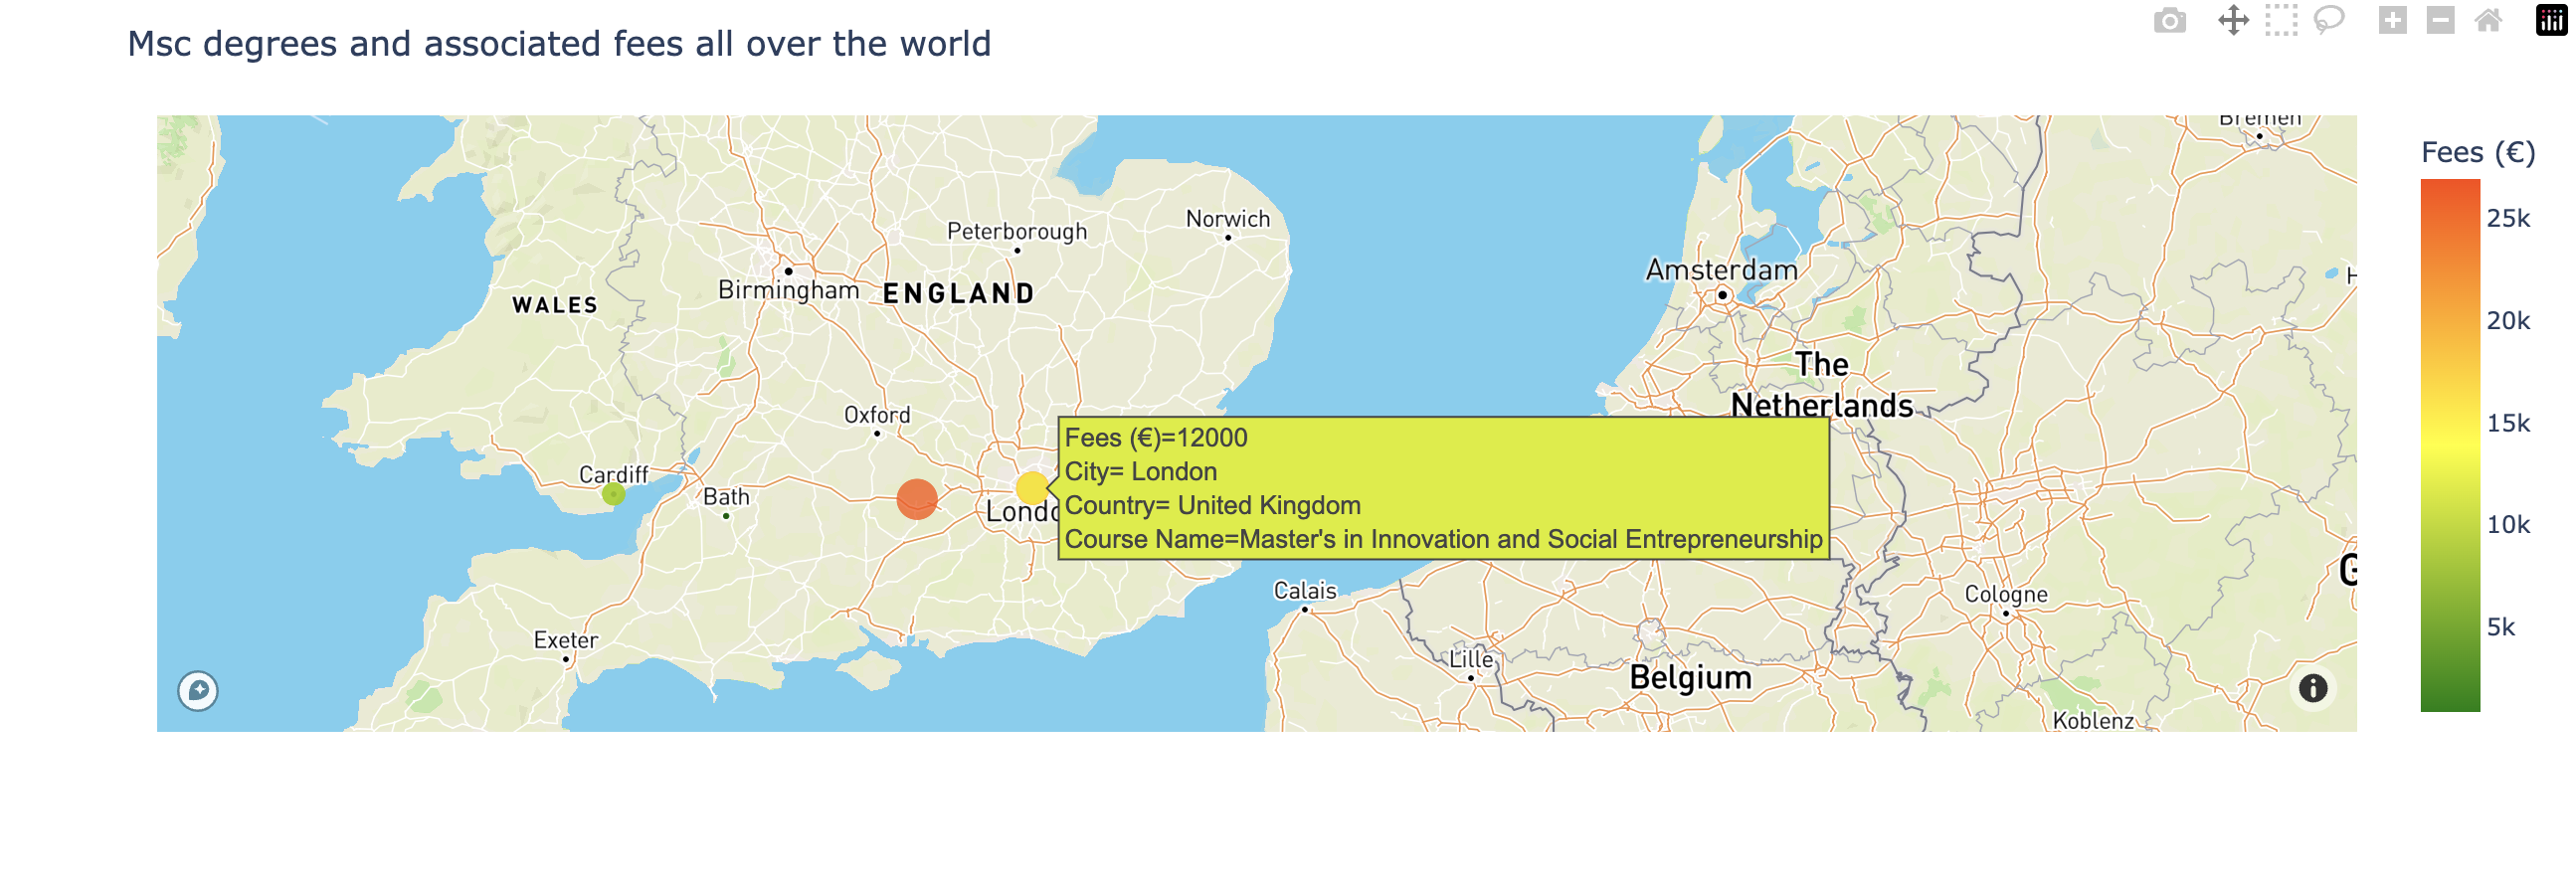

# 6. Command Line Question

To work on the command line question, since I have a Windows operating system, I used Cygwin that allowed me to use Linux commands.

To tackle the first request to merge all the tsv file created in the first question, I first manually added the column names to the first tsv file and then I used the cat command that concatenates the contents of all .tsv files that start with course_ and writes them into merged_courses.tsv. 

In the repository you will find both the CommandLine.sh file with the commented code for the required questions and the screenshot of the results.

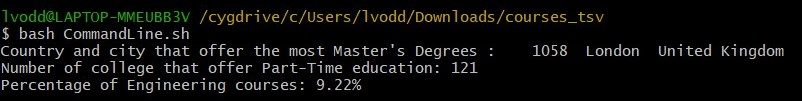

We use "bash CommandLine.sh" to execute the CommandLine.sh file

# 7. Algorithmic Question (AQ)

In [ ]:
from itertools import product

def input_day_hours():
    return map(int, input().split())

def main():
    # Input the total number of days and the total number of hours
    total_days, sum_hours = map(int, input().split())

    # Initialize a list to store the ranges of hours for each day
    day_min_max = []

    # Input the minimum and maximum hours for each day and create a list of ranges
    for _ in range(total_days):
        min_hours, max_hours = input_day_hours()
        day_min_max.append(list(range(min_hours, max_hours + 1)))

    def find_combinations_with_sum(nested_list, target_sum):
        # Get the minimum and maximum hours for each day
        min_hours = [day[0] for day in nested_list]
        max_hours = [day[-1] for day in nested_list]

        # Check if the total hours are within the valid range
        if sum_hours in range(sum(min_hours), sum(max_hours) + 1):
            print('YES')
        else:
            print('NO')

        # Iterate through all combinations of hours and print those with the target sum
        for combination in product(*nested_list):
            if sum(combination) == target_sum:
                print(*combination)

    # Call the function with the provided day_min_max and sum_hours
    find_combinations_with_sum(day_min_max, sum_hours)

if __name__ == "__main__":
    main()

 1 1
 2 3


NO


2. time complexity :</br>
Initializing min_hours and max_hours takes O(total_days).</br>
Checking the total hours range is done in O(1) or constant.</br>
Generating combinations takes O(product of sizes of nested_list).</br>
Overall, the dominant factor is generating combinations, making the overall time complexity O(product of sizes of nested_list).

3. chatgpt generated code : </br>
the chatgpt generated code is correct and it is even more optimized, because it uses some kind of algorithm which does not generate all combinations.

4. being more optimized :</br>
as we mentioned on section 3, the code can be more optimized using backtracking algorithm which avoids generating all combinations and searches among the valid combinations more effectively.